Владимир Кирилкин ПИ18-2

ML 3.1. Оценка эффективности
https://docs.google.com/document/d/1PbYLySVwPjlzKMbDfwAM-NbReoUTGRaOIGLocZ8F-Rg/edit
Источник данных
https://www.kaggle.com/kemical/kickstarter-projects

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ks-projects-201801.csv")
data.head()

In [2]:
data = pd.read_csv("ks-projects-201801.csv")
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Общая характеристика набора данных:

Количество наблюдений 378661 -> 331675

Признаков 15 -> 10

Предметная область — результат привлечения частных инвестиций на платформе KickStarter

Задача обучения — классификация, будет ли проект успешно завершен

Структура данных

| Имя              | Значение                                                     | Пригодность |
| ---------------- | ------------------------------------------------------------ | ----------- |
| id               | ID                                                           | ❌           |
| name             | Название                                                     | ✔           |
| category         | Подкатегория                                                 | ✔           |
| main_category    | Категория                                                    | ✔           |
| currency         | Валюта                                                       | ❌           |
| deadline         | Дата завершения                                              | ❌           |
| goal             | Цель в валюте проекта                                        | ❌           |
| launched         | Дата начала                                                  | ✔           |
| pledged          | Привлеченные средства в валюте проекта                       | ❌           |
| state            | Статус                                                       | ✔           |
| backers          | Количество вложившихся                                       | ❌           |
| country          | Страна                                                       | ✔           |
| usd pledged      | Привлеченные средства в USD (конвертация через KS)           | ❌           |
| usd_pledged_real | Привлеченные средства в USD (конвертация через fixer.io api) | ✔           |
| usd_goal_real    | Цель в USD                                                   | ✔           |
| days             | Время проекта в днях                                         | ✔           |



Добавляем дни

In [3]:
data["launched"] = pd.to_datetime(data["launched"], format="%Y-%m-%d %H:%M:%S")
data["days"] = (pd.to_datetime(data["deadline"], format="%Y-%m-%d") - data["launched"]).dt.days

Удаляем лишние данные

In [4]:
data.pop("ID")
data.pop("currency")
data.pop("deadline")
data.pop("goal")
data.pop("pledged")
data.pop("usd pledged")
data.pop("backers")

0          0
1         15
2          3
3          1
4         14
          ..
378656     1
378657     5
378658     1
378659     6
378660    17
Name: backers, Length: 378661, dtype: int64

Удаляем лишние статусы и приводим к success = True/False

In [5]:
states = ["failed", "successful"]
data = data.query("state in @states")
data["success"] = data["state"] == "successful"
data.pop("state")
data

,name,category,main_category,launched,country,usd_pledged_real,usd_goal_real,days,success
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11 12:12:28,GB,0.0,1533.95,58,False
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02 04:43:57,US,2421.0,30000.00,59,False
2,Where is Hank?,Narrative Film,Film & Video,2013-01-12 00:20:50,US,220.0,45000.00,44,False
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-03-17 03:24:11,US,1.0,5000.00,29,False
5,Monarch Espresso Bar,Restaurants,Food,2016-02-26 13:38:27,US,52375.0,50000.00,34,True
...,...,...,...,...,...,...,...,...,...
378654,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,2017-03-20 22:08:22,US,154.0,6500.00,29,False
378657,The Tribe,Narrative Film,Film & Video,2011-06-22 03:35:14,US,155.0,1500.00,26,False
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,2010-07-01 19:40:30,US,20.0,15000.00,45,False
378659,BioDefense Education Kit,Technology,Technology,2016-01-13 18:13:53,US,200.0,15000.00,30,False


In [6]:
data["category"] = data["category"].astype('category')
data["main_category"] = data["main_category"].astype('category')
data["country"] = data["country"].astype('category')

In [50]:
data.head()

,name,category,main_category,launched,country,usd_pledged_real,usd_goal_real,days,success
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11 12:12:28,GB,0.0,1533.95,58,False
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02 04:43:57,US,2421.0,30000.00,59,False
2,Where is Hank?,Narrative Film,Film & Video,2013-01-12 00:20:50,US,220.0,45000.00,44,False
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-03-17 03:24:11,US,1.0,5000.00,29,False
5,Monarch Espresso Bar,Restaurants,Food,2016-02-26 13:38:27,US,52375.0,50000.00,34,True


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   name              331672 non-null  object        
 1   category          331675 non-null  category      
 2   main_category     331675 non-null  category      
 3   launched          331675 non-null  datetime64[ns]
 4   country           331675 non-null  category      
 5   usd_pledged_real  331675 non-null  float64       
 6   usd_goal_real     331675 non-null  float64       
 7   days              331675 non-null  int64         
 8   success           331675 non-null  bool          
dtypes: bool(1), category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 16.8+ MB


In [52]:
data.describe()

,usd_pledged_real,usd_goal_real,days
count,3.316750e+05,3.316750e+05,331675.000000
mean,9.943461e+03,4.151000e+04,32.954902
std,9.673293e+04,1.108930e+06,12.713329
min,0.000000e+00,1.000000e-02,0.000000
25%,5.000000e+01,2.000000e+03,29.000000
50%,7.880000e+02,5.000000e+03,29.000000
75%,4.608000e+03,1.500000e+04,35.000000
max,2.033899e+07,1.663614e+08,91.000000


In [53]:
data.isna().any()

name                 True
category            False
main_category       False
launched            False
country             False
usd_pledged_real    False
usd_goal_real       False
days                False
success             False
dtype: bool

na только name, что не критично

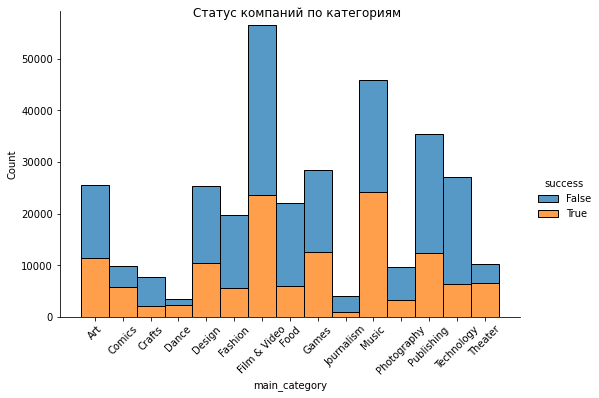

In [11]:
g = sns.displot(data=data, x="main_category", hue="success", multiple="stack", aspect=1.5)
g.set_xticklabels(rotation=45)
g.fig.suptitle("Статус компаний по категориям")
g

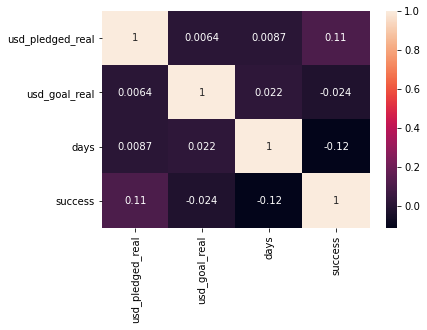

In [16]:
corr = data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)

# sns.histplot(data.aggregate({"usd_pledged_real": "sum"}), x="category", y="usd_pledged_real")

In [24]:
t = data.head(200)
# data.aggregate({"usd_pledged_real": "sum"})


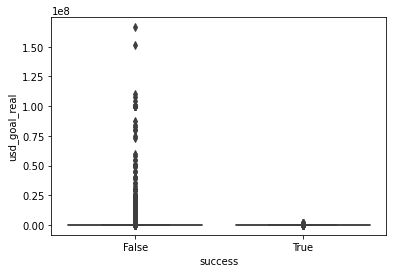

In [56]:
g = sns.boxplot(data=data,  y="usd_goal_real", x="success")
g

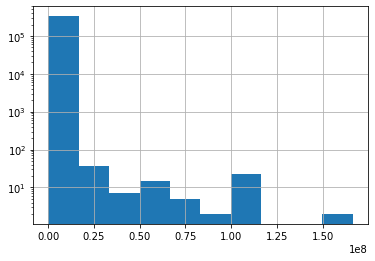

In [22]:
data["usd_goal_real"].hist(log=True)

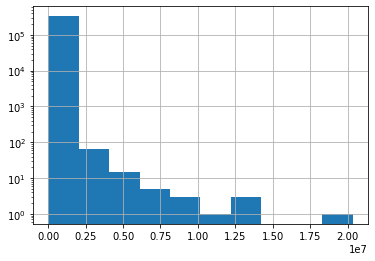

In [21]:
data["usd_pledged_real"].hist(log=True)

In [13]:
# data["backers"].hist()

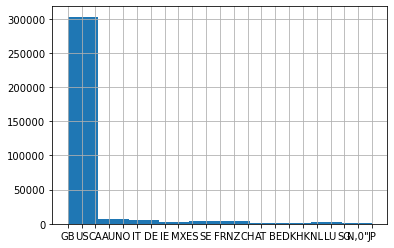

In [98]:
data["country"].hist()

In [34]:
data["country"].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

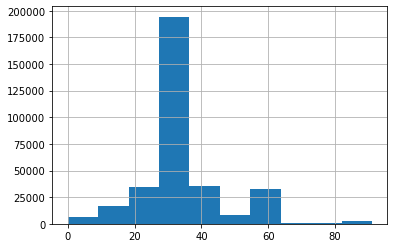

In [18]:
data["days"].hist()

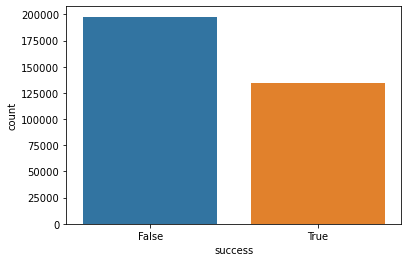

In [17]:
sns.countplot(x=data["success"])

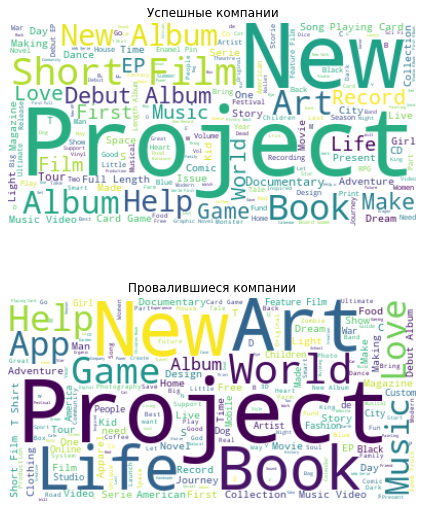

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

wordcloud = WordCloud(background_color="white").generate(data.query("success == True")["name"].to_string())

axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Успешные компании")

wordcloud = WordCloud(background_color="white").generate(data.query("success == False")["name"].to_string())

axes[1].imshow(wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Провалившиеся компании")
fig.tight_layout()

In [7]:
X = data.drop(["name", "success", "launched","category","usd_pledged_real"], axis=1)
categories = {"Music", "Theater", "Technology", "Fashion", "Comics", "Food", "Crafts", "Publishing", "Dance"}
X["main_category"] = X["main_category"].apply(lambda x: x if x in categories else "OT_CAT")
X = X.join(pd.get_dummies(X['main_category'])).drop(["main_category", "OT_CAT"], axis=1)
X["country"] = X["country"].apply(lambda x: x if x in {"US"} else "OT_COUNTRY")
X = X.join(pd.get_dummies(X['country'])).drop(["country", "OT_COUNTRY"], axis=1)
y = data["success"]
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                   random_state=2)

In [8]:
x_train.head()

,usd_goal_real,days,Comics,Crafts,Dance,Fashion,Food,Music,Publishing,Technology,Theater,US
142793,22319.93,59,0,0,0,1,0,0,0,0,0,0
15230,4000.00,36,0,0,0,0,0,0,0,0,1,1
104984,1315.12,24,0,0,0,0,0,1,0,0,0,0
60498,900.00,44,0,0,0,0,0,0,0,0,0,1
118515,7300.00,13,0,0,0,0,0,0,0,0,0,1


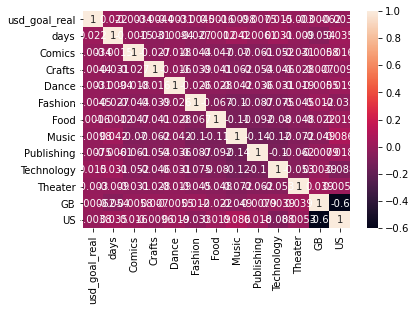

In [55]:
corr = X.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)

Поиск лучших параметров через GridSearchCV

In [63]:
rfc = RandomForestClassifier(n_jobs=-1)
param_grid = {
    'n_estimators': [50, 200, 700],
    "max_depth": [3,7,11],
    "min_samples_split": [2,3,5,7],
    'max_features': ['sqrt', 'log2']
}

In [64]:
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 2, verbose=1, n_jobs=-1)

In [65]:
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 13.1min finished


{'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_split': 3,
 'n_estimators': 700}

Второй подход поиска лучших параметров через GridSearchCV

In [72]:
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    "max_depth": [9, 11, 13, 15, 17],
    "min_samples_split": [7, 9, 11, 13],
    'max_features': ['sqrt', 'log2']
}

In [73]:
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 2, verbose=1, n_jobs=-1)

In [74]:
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_

Fitting 2 folds for each of 160 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  8.9min finished


{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 100}

Так как параметры остались в границах поиска, то искать дальше более лучшие параметры смысла нет,
так как прирост качества будет незначительным

In [66]:
cls = RandomForestClassifier(n_jobs=-1,
    **{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 100})

cls.fit(x_train, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=9,
                       n_jobs=-1)

In [50]:
cls = RandomForestClassifier(n_jobs=-1,
    **{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 100})

cls.fit(x_train, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=9,
                       n_jobs=-1)

In [67]:
cls.score(x_train, y_train)

0.680333338693338

In [68]:
cls.score(x_test, y_test)

0.6611271240608304

In [69]:
predicted = cls.predict(x_test)
print('accuracy_score:', accuracy_score(y_test, predicted))
print('precision_score:', precision_score(y_test, predicted))
print('recall_score:', recall_score(y_test, predicted))
print('f1_score:', f1_score(y_test, predicted))

accuracy_score: 0.6611271240608304
precision_score: 0.6095738909060556
recall_score: 0.4379610194902549
f1_score: 0.5097101778018182


In [78]:
predicted = cls.predict(x_test)
print('accuracy_score:', accuracy_score(y_test, predicted))
print('precision_score:', precision_score(y_test, predicted))
print('recall_score:', recall_score(y_test, predicted))
print('f1_score:', f1_score(y_test, predicted))

accuracy_score: 0.6632496773960129
precision_score: 0.6248332336568984
recall_score: 0.40725637181409297
f1_score: 0.49311089730789476


Качество модели получилось довольно низким, возможно стоит попробовать другую модель

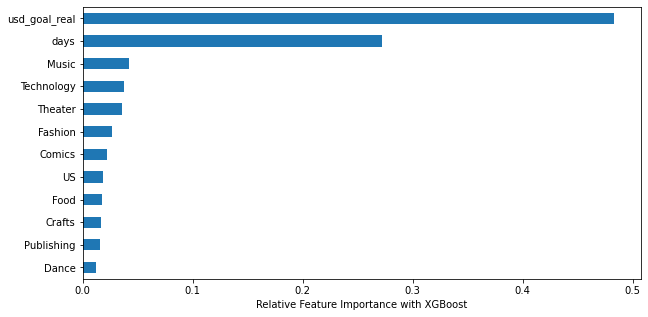

In [70]:
feat_importances = pd.Series(cls.feature_importances_, index=x_train.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(10,5))

Берем GPU, ставим CUDA Toolkit и запускаем XGBoosterClassifier на GPU

In [27]:
!C:\"Program Files"\"NVIDIA Corporation"\NVSMI\nvidia-smi.exe

Wed Dec 02 10:42:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.81       Driver Version: 456.81       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test  = sc.transform(x_test)

На гриде нахожу оптимальные параметры для буста

In [13]:
booster = xgb.XGBClassifier(tree_method='gpu_hist')

In [15]:
param_grid = {'n_estimators': [100, 150, 200, 250],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2, 0.25],
}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 96.7min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 114.3min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='gpu_his

In [16]:
booster_grid_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 250}

Обучаю модель на оптимальных параметрах

In [17]:
booster = xgb.XGBClassifier(tree_method='gpu_hist', **{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 250}
)


booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)

In [28]:
print('accuracy_score:', accuracy_score(y_test, y_pred_test))
print('precision_score:', precision_score(y_test, y_pred_test))
print('recall_score:', recall_score(y_test, y_pred_test))
print('f1_score:', f1_score(y_test, y_pred_test))

accuracy_score: 0.6641300546316284
precision_score: 0.6105749899477282
recall_score: 0.4553223388305847
f1_score: 0.5216420474063895


In [29]:
booster.score(X_train, y_train)

0.6655839457138722

In [19]:
booster.score(X_test, y_test)

0.6641300546316284

Находим лучший сид рандома

In [55]:
X = data.drop(["name", "success", "launched","category","usd_pledged_real"], axis=1)
X = X.join(pd.get_dummies(X['main_category'])).drop(["main_category"], axis=1)
X["country"] = X["country"].apply(lambda x: x if x in {"US"} else "OT_COUNTRY")
X = X.join(pd.get_dummies(X['country'])).drop(["country", "OT_COUNTRY"], axis=1)
y = data["success"]

booster = xgb.XGBClassifier(tree_method='gpu_hist', **{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 250}
)
best = [0, 0]
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                   random_state=i)
    sc = StandardScaler()
    X_train = sc.fit_transform(x_train)
    X_test  = sc.transform(x_test)

    booster.fit(X_train, y_train)

    y_pred_test = booster.predict(X_test)
    score_test = booster.score(X_test, y_test)

    if score_test > best[1]:
        best = [i, score_test]

    print(f"""\nrandom={i}
score train {booster.score(X_train, y_train)}
score test {score_test}
precision_score {precision_score(y_test, y_pred_test)}
recall_score {recall_score(y_test, y_pred_test)}
f1_score {f1_score(y_test, y_pred_test)}""")


random=0
score train 0.6689044686359324
score test 0.6686043005824962
precision_score 0.6156713458640654
recall_score 0.46606429922252574
f1_score 0.5305222873349165

random=1
score train 0.6696280692727009
score test 0.6678204030439344
precision_score 0.6167936520468991
recall_score 0.4669316517737067
f1_score 0.5315008844740781

random=2
score train 0.6692622489507791
score test 0.6674706641421146
precision_score 0.6134480185381564
recall_score 0.468335832083958
f1_score 0.5311591368961589

random=3
score train 0.6700582096512245
score test 0.6665299870958405
precision_score 0.6119022400062767
recall_score 0.46762201702842066
f1_score 0.5301204819277109

random=4
score train 0.6693064689896927
score test 0.6676756834983538
precision_score 0.6193084149510294
recall_score 0.4621029082774049
f1_score 0.5292791253843525

random=5
score train 0.6703757899306951
score test 0.6643712538742629
precision_score 0.6113971170600349
recall_score 0.4614717838354854
f1_score 0.525958983443483

ran


random=50
score train 0.6698411294601939
score test 0.6665420470579723
precision_score 0.6102095478178667
recall_score 0.4659808698790832
f1_score 0.5284306034041683

random=51
score train 0.6702511698210294
score test 0.665734029595147
precision_score 0.6134486981944609
recall_score 0.4640466228332337
f1_score 0.5283898521379593

random=52
score train 0.6706692501889402
score test 0.6646606929654241
precision_score 0.6165891657724256
recall_score 0.4607252101089894
f1_score 0.5273821259815753

random=53
score train 0.670154689736127
score test 0.665179271337088
precision_score 0.6114802437586003
recall_score 0.4651851408745588
f1_score 0.5283935517844707

random=54
score train 0.6715858109955136
score test 0.6619954413343142
precision_score 0.6130301361240066
recall_score 0.46137447073105736
f1_score 0.5264989609906913

random=55
score train 0.6701104696972133
score test 0.6661078884212304
precision_score 0.6124356435643564
recall_score 0.4634935859009711
f1_score 0.527655508922783



In [56]:
best

[66, 0.6702806353188051]

Получаем значимость параметров

0.6619954413343142


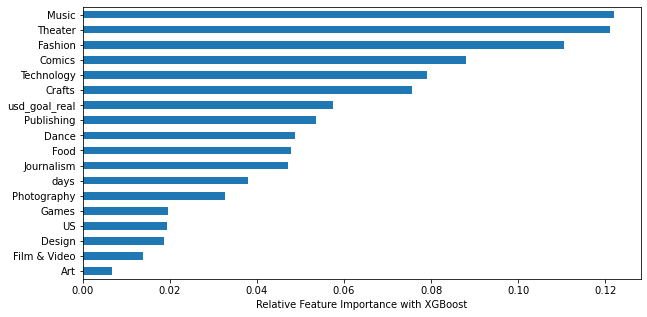

In [37]:
X = data.drop(["name", "success", "launched","category","usd_pledged_real"], axis=1)
X = X.join(pd.get_dummies(X['main_category'])).drop(["main_category"], axis=1)
X["country"] = X["country"].apply(lambda x: x if x in {"US"} else "OT_COUNTRY")
X = X.join(pd.get_dummies(X['country'])).drop(["country", "OT_COUNTRY"], axis=1)
y = data["success"]
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                   random_state=66)

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test  = sc.transform(x_test)

booster = xgb.XGBClassifier(tree_method='gpu_hist', **{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 250}
)

booster.fit(X_train, y_train)

print(booster.score(X_test, y_test))

feat_importances = pd.Series(booster.feature_importances_, index=x_train.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');


Сортируем категории по их значимости и пробуем дропнуть самые малозначимые

In [52]:
data_dropped = data.drop(["name", "success", "launched","category","usd_pledged_real"], axis=1)
data_dropped["country"] = data_dropped["country"].apply(lambda x: x if x in {"US"} else "OT_COUNTRY")
data_dropped = data_dropped.join(pd.get_dummies(data_dropped['country'])).drop(["country", "OT_COUNTRY"], axis=1)
categories_list = ["Music", "Theater", "Fashion", "Comics","Technology",  "Crafts","Publishing","Dance","Food", "Journalism", "Photography", "Games", "Design", "Film & Video", "Art"]
y = data["success"]

for i in range(7):
    X = data_dropped.copy()
    categories = set(categories_list[:-i if i != 0 else None])
    X["main_category"] = X["main_category"].apply(lambda x: x if x in categories else "OT_CAT")
    X = X.join(pd.get_dummies(X['main_category'])).drop(["main_category"], axis=1)
    if i!=0: X.drop(["OT_CAT"], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                       random_state=54)
    sc = StandardScaler()
    X_train = sc.fit_transform(x_train)
    X_test  = sc.transform(x_test)

    booster = xgb.XGBClassifier(tree_method='gpu_hist', **{'colsample_bytree': 0.7,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 5,
     'n_estimators': 250}
    )

    booster.fit(X_train, y_train)

    print(i, booster.score(X_test, y_test))

0 0.6623693001603975
1 0.6623693001603975
2 0.6616336424703626
3 0.6614648030005186
4 0.6608859248181961
5 0.6599814276583171
6 0.6593060697789409


Получается что дропать категории - только хуже

Лучший результат на XGBClassifier

In [59]:
X = data.drop(["name", "success", "launched","category","usd_pledged_real"], axis=1)
X = X.join(pd.get_dummies(X['main_category'])).drop(["main_category"], axis=1)
X["country"] = X["country"].apply(lambda x: x if x in {"US"} else "OT_COUNTRY")
X = X.join(pd.get_dummies(X['country'])).drop(["country", "OT_COUNTRY"], axis=1)
y = data["success"]
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                   random_state=66)
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test  = sc.transform(x_test)

booster = xgb.XGBClassifier(tree_method='gpu_hist', **{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 250}
)


booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred_test))
print('precision_score:', precision_score(y_test, y_pred_test))
print('recall_score:', recall_score(y_test, y_pred_test))
print('f1_score:', f1_score(y_test, y_pred_test))

accuracy_score: 0.6702806353188051
precision_score: 0.6194173991879853
recall_score: 0.47049312853678255
f1_score: 0.5347808331064525
